# 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.2)
%matplotlib inline
color = sns.color_palette()

#RAW_PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/raw/'
RAW_PATH = 'D:/project/해커톤/data/'# 로컬용
#PREPARED_PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/prepared/'
PREPARED_PATH = 'J:/.shortcut-targets-by-id/1CmFyW0xQERiGa58Updu5HVh0niAWQSBA/prepared/' # 로컬용

In [3]:
prior_df = pd.read_pickle(PREPARED_PATH + 'prior_df.pkl') # order_product__prior.csv + orders.csv + products.csv
prior_order_feats = pd.read_pickle(PREPARED_PATH + 'prior_order_feats.pkl') # orders.csv + @
prod_feats = pd.read_pickle(PREPARED_PATH + 'prod_feats.pkl') # products.csv + @
user_feats = pd.read_pickle(PREPARED_PATH + 'user_feats.pkl')
user_prod_feats = pd.read_pickle(PREPARED_PATH + 'user_prod_feats.pkl')
orders = pd.read_csv(RAW_PATH + 'orders.csv', dtype={'order_id': np.uint32, 'user_id': np.uint32, 'eval_set': 'category', 'order_number': np.uint8,         
                                                     'order_dow': np.uint8, 'order_hour_of_day': np.uint8, 'days_since_prior_order': np.float16})

# 1. 가설 검정 체크표

![image](https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fc996ac5c-5f4e-4a8f-80cd-58ab89890672%2FUntitled.png?table=block&id=46dfc3c8-7066-4fe0-bc72-a614577ac81b&spaceId=c09f8228-29c7-4dcb-8ca3-1de7d3988fab&name=Untitled.png&userId=ae04a864-995c-417d-940e-9cc2d0bcc2fe&cache=v2)

# 2. 주말&요일이 구매에 미치는 영향

## 2.1. 특정 요일 & 시간대에 팔리는 제품 패턴이 있나?


In [4]:
def topItemEachGroup(ds, group_name, sort_name, topn):
    concat_list = []
    for (key, rows) in ds.groupby(group_name):
        sub_ds = rows.sort_values(sort_name, ascending=False)[:topn]
        sub_ds['rank'] = list(range(1,topn+1))
        concat_list.append(sub_ds)

    return pd.concat(concat_list)

In [5]:
def drawRankTrend(pivot_ds, ylabel='Rank'):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.3, rc={'font.family':'NanumGothic'} )

    index_max = pivot_ds.index.max()
    rank_max = pivot_ds.max().max()
    pivot_ds = pivot_ds.applymap(lambda x:rank_max-x+1)
    pivot_ds.plot(marker='o', figsize=(20,12), cmap='Dark2', xticks=pivot_ds.index, legend=None )
    
    plt.yticks(np.arange(rank_max,0,-1), np.arange(1,rank_max+1))
    for name, rank in pivot_ds.loc[index_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(index_max*1.01,rank,name)
    plt.ylabel(ylabel)
    plt.show()
    

In [7]:
hour_product_ds = prior_df.groupby(['product_name','order_hour_of_day'], as_index=False).agg({'order_id':len})
hour_top_product_ds = topItemEachGroup(hour_product_ds, 'order_hour_of_day', 'order_id' , 20)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', columns='product_name', values='rank') 

### 시간별 제품 판매 트랜트 확인

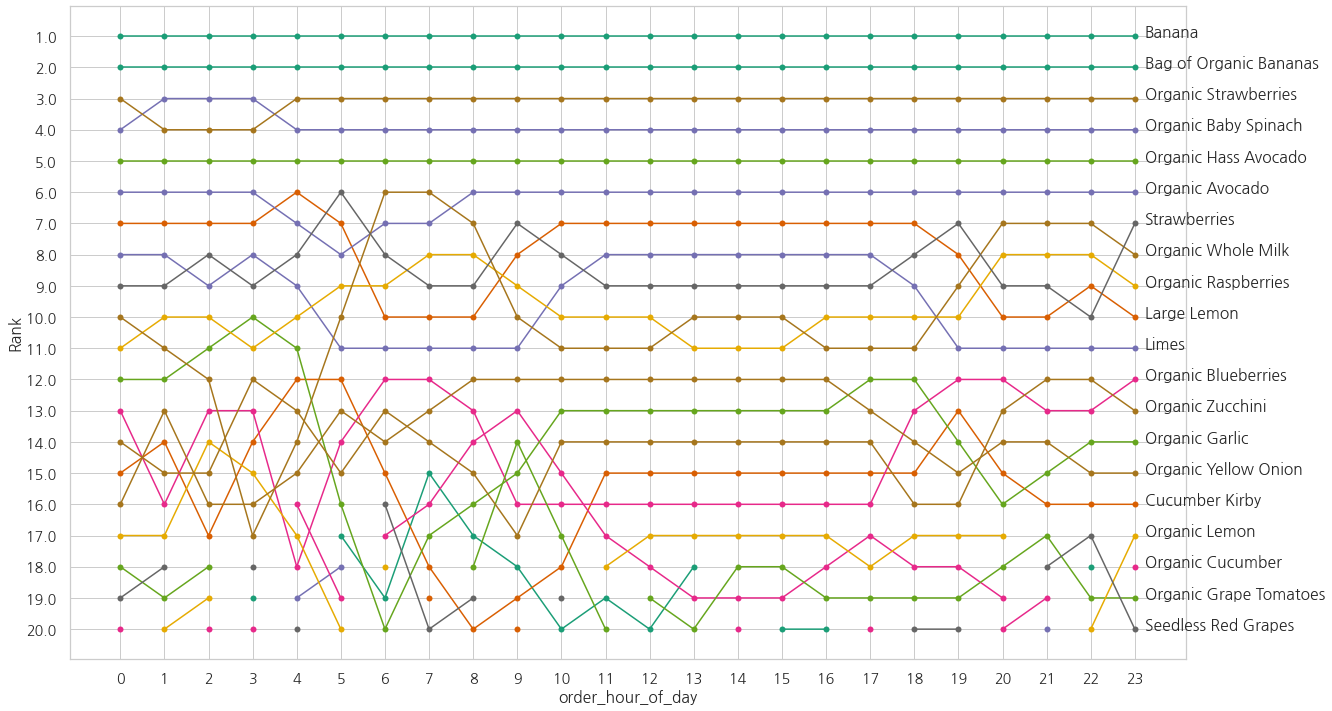

In [8]:
drawRankTrend(hour_top_product_pivot_ds)

### 요일별 제품 판매 트랜드 확인

In [9]:
# 요일별 판매량 트랜드
rank_ds = prior_df.groupby(['product_name','order_dow'], as_index=False).agg({'order_id':len})
rank_ds = topItemEachGroup(rank_ds, 'order_dow', 'order_id' , 20)
rank_pivot_ds = rank_ds.pivot(index='order_dow', columns='product_name', values='rank') 

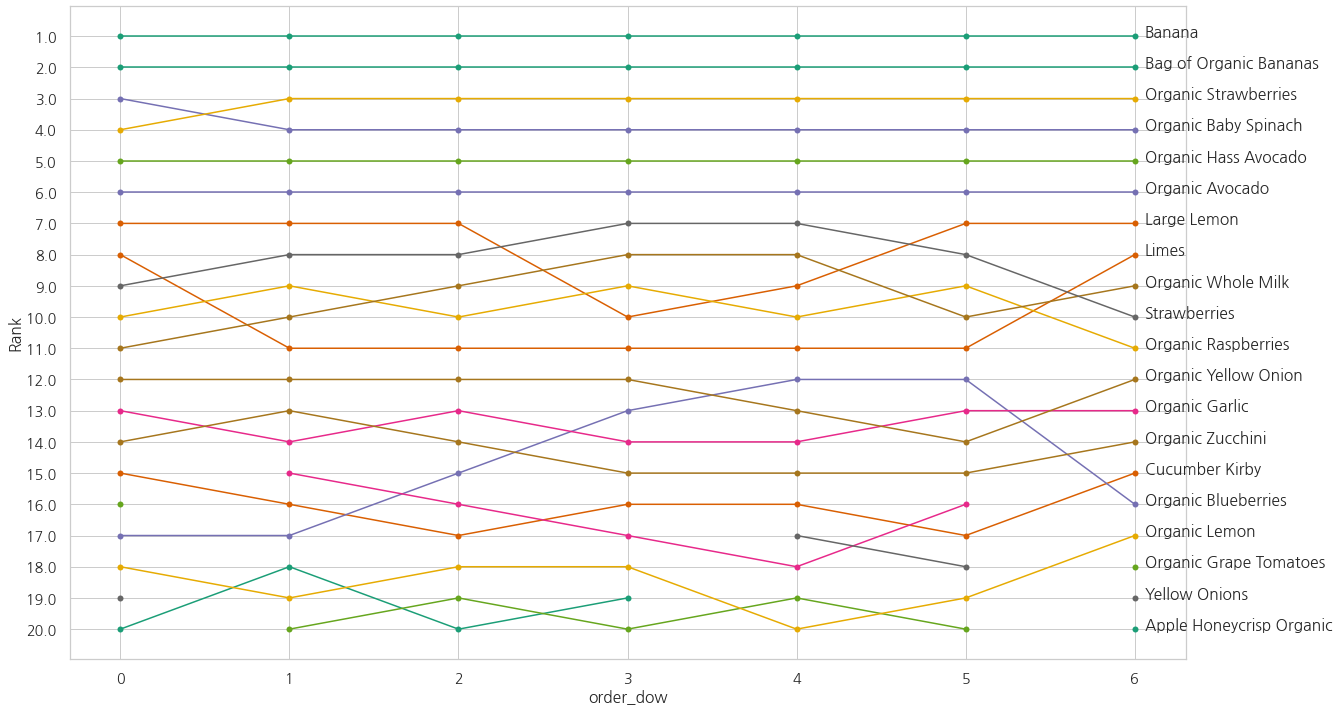

In [10]:
drawRankTrend(rank_pivot_ds)

### 주말과 평일에 많이 팔리는 제품 리스트 확인


In [12]:
prior_df[prior_df.order_dow < 2].product_name.value_counts().head(20)

Banana                      184556
Bag of Organic Bananas      141219
Organic Strawberries        100192
Organic Baby Spinach         97191
Organic Hass Avocado         82506
Organic Avocado              72130
Large Lemon                  60445
Limes                        53398
Strawberries                 52818
Organic Raspberries          50653
Organic Whole Milk           49475
Organic Yellow Onion         45527
Organic Garlic               43113
Organic Zucchini             42528
Cucumber Kirby               39489
Organic Blueberries          36611
Organic Fuji Apple           35024
Organic Grape Tomatoes       34602
Organic Lemon                33744
Apple Honeycrisp Organic     33579
Name: product_name, dtype: int64

In [13]:
prior_df[prior_df.order_dow > 1].product_name.value_counts().head(20)

Banana                      288009
Bag of Organic Bananas      238231
Organic Strawberries        164491
Organic Baby Spinach        144730
Organic Hass Avocado        131078
Organic Avocado             104685
Large Lemon                  92212
Strawberries                 90133
Organic Whole Milk           88430
Limes                        87229
Organic Raspberries          86404
Organic Yellow Onion         67899
Organic Garlic               66665
Organic Blueberries          63449
Organic Zucchini             62295
Cucumber Kirby               57826
Organic Fuji Apple           54608
Organic Lemon                54002
Seedless Red Grapes          51823
Apple Honeycrisp Organic     51441
Name: product_name, dtype: int64

### 요일과 시간 히트맵

In [14]:
# 0~6 카테고리를 요일명으로 변환
index2day = "Sat Sun Mon Tue Wed Thu Fri".split()

In [15]:
# 히트맵 그리는 함수
def drawWeekHour(ds, values,  aggfunc=len, title=None, figsize=(18,5) , cmap=None):
    weekhour_ds = ds.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_ds.index =  [  index2day[index] for index in weekhour_ds.index]
    sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_ds, annot=True, fmt="1.1f", linewidths=.5, cmap=cmap) 
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize=15)

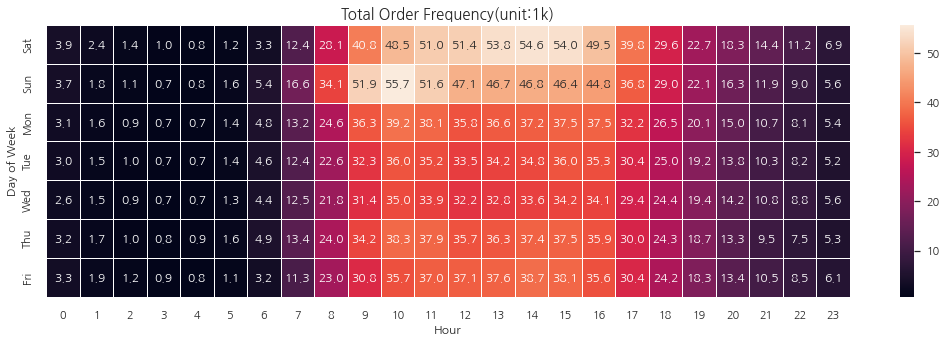

In [16]:
# 요일 x 시간
drawWeekHour(orders, values='order_id', title="Total Order Frequency(unit:1k)", aggfunc=lambda x: len(x)/1000)

앞서 확인했던것처럼 주말(0~1)과 09~17시 사이에 주문이 많은 것을 볼 수 있다.
* 이 주문들은 주문하는 고객이 많은 건지? 고객 당 주문 건수가 많은 건지?

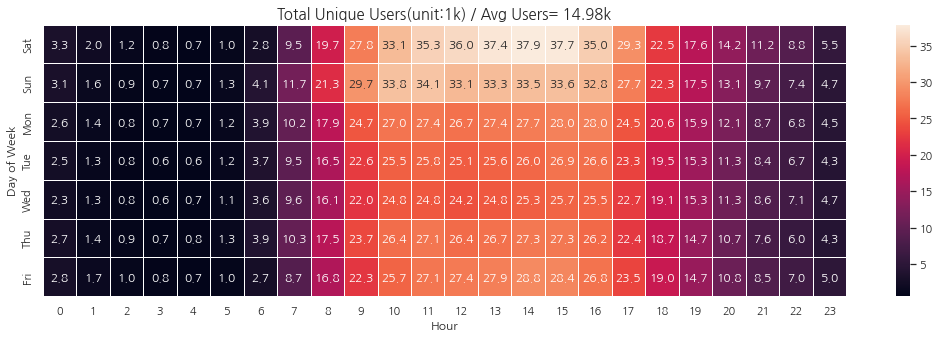

In [ ]:
# 요일-시간대 별 발생한 주문 건수 중 unique한 user 확인

avg_users = round(orders.groupby(['order_dow','order_hour_of_day']).agg({'user_id':lambda x: len(x.unique())/1000}).mean().values[0],2)
drawWeekHour(orders, values='user_id', title="Total Unique Users(unit:1k) / Avg Users= {}k".format(avg_users), aggfunc=lambda x: len(x.unique())/1000)

전체 주문건수와 유사한 것이 확인된다.

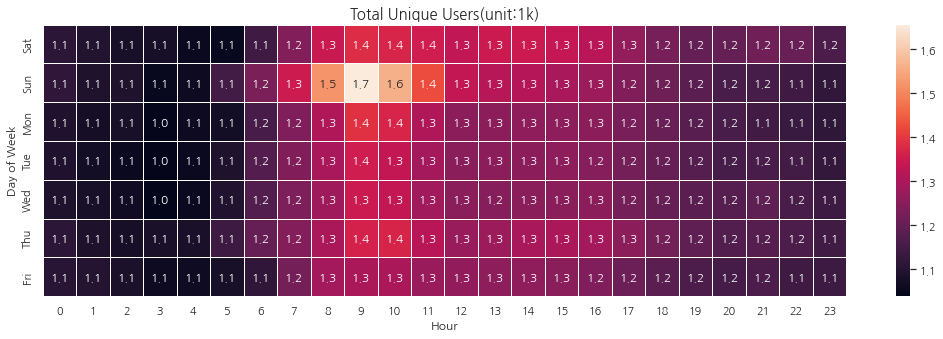

In [ ]:
# 요일-시간대 별 발생한 주문 중 user_id당 몇 건의 주문이 발생했는지 확인

drawWeekHour(orders, values='user_id', title='Total Unique Users(unit:1k)', aggfunc=lambda x: len(x)/len(x.unique()))

1번 요일(일요일 추정)의 8-10h 때 많은 주문 건수가 발생하는 게 확인된다.  
    * 한 사람이 1회 이상의 order를 넣을 이유는 무엇일까?   
    * 주말에 장을 본 후 누락한 물건들을 추가로 장을 보는 것인지?  
    * instacart에는 정기배송(정기구매) 시스템이 있어 해당 요일에 자동으로, 별도의 order_id로 결제가 진행되는 건지?  

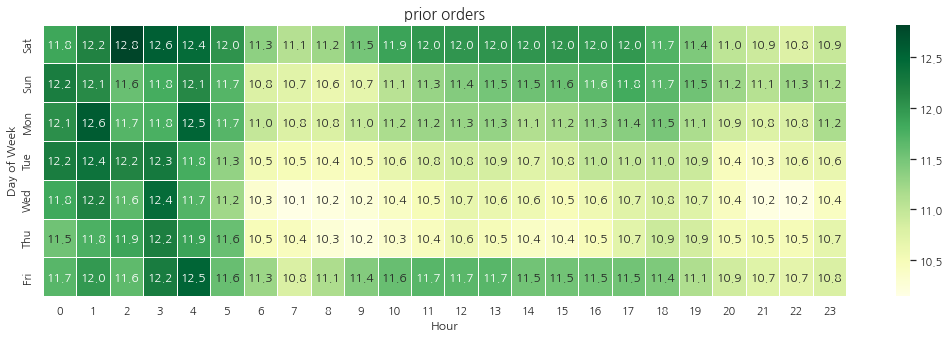

In [ ]:
# 요일-시간대 별 발생한 주문들의 재구매까지 걸리는 평균 일수

drawWeekHour(orders, values='days_since_prior_order', title="prior orders", aggfunc=lambda x: np.mean(x), cmap='YlGn')

`days_since_prior_order`의 경우 7일과 30일 주기가 가장 많았고, 14, 21, 28등 7일 주기가 그 다음으로 많았다.  
이를 비춰봤을 때 `days_since_prior_order`의 요일-시간대 별 전체 평균은 유의미한 패턴 확인이 어려울 것으로 보인다.
* 7일 이하 / 8~29일 / 30일로 나눠서 확인해본다면 차이가 있을까?

금요일과 토요일, 0~6시 새벽시간 대에 발생한 주문이 다음 주문까지 기간이 길게 나타남
* 새벽 2~6시 등 일반적으로 장을 보지않는 시간대라서 재주문 텀이 길게 나타나는 게 아닌지?

In [ ]:
a = priors.groupby('order_id')['product_id'].count().reset_index().rename(columns={'order_id':'order_id','product_id' : 'items'})
orders = orders.merge(a, on='order_id', how='left')

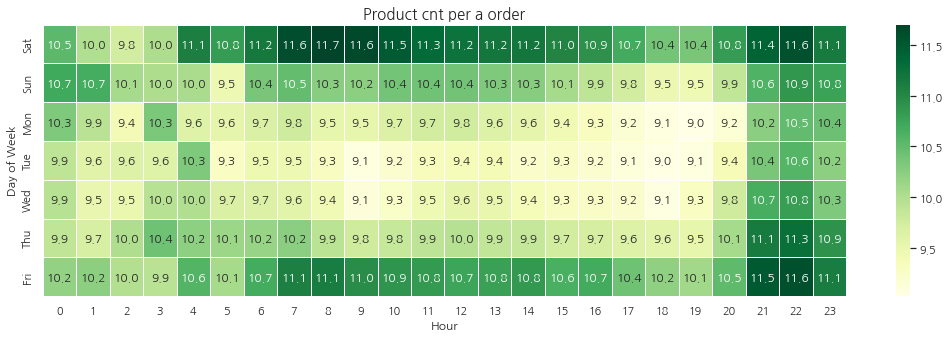

In [ ]:
# 요일-시간대 별 발생한 주문들의 평균 구매제품 수
drawWeekHour(orders, values='items', title="Product cnt per a order", aggfunc=lambda x: np.mean(x), cmap='YlGn')

금요일과 토요일에 발생한 주문의 상품 주문 개수가 많음  
오전 7-8h와 오후 21-23h에 주문 개수가 많음
* 

## 2.2. 특정 요일 & 시간대에만 구매하는 고객 패턴이 있나?

In [29]:
# 유저의 전체 주문 중 특정 요일에 주문을 80%이상 진행한 유저
user_dow[user_dow.percent_of_orders >=0.8].order_dow.value_counts().sort_index()

0    1945
1     942
2     286
3     278
4     280
5     502
6     623
Name: order_dow, dtype: int64

<AxesSubplot:>

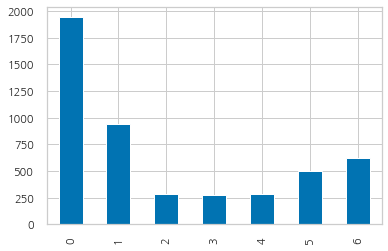

In [25]:
# 요일 선호 유저의 분포 시각화
user_dow = prior_order_feats.groupby(['user_id', 'order_dow']).size().reset_index().rename(columns=({0:'dow_count'}))
user_dow = user_dow.merge(user_feats[['user_id', 'U_total_orders']], on='user_id', how='left')
user_dow['percent_of_orders'] = user_dow.dow_count / user_dow.U_total_orders
user_dow[user_dow.percent_of_orders >=0.8].user_id.nunique() 

# 50% 이상 구매하는 요일이 있는 유저 수 57424
# 80% 이상 구매하는 요일이 있는 유저 수 4856

user_dow[user_dow.percent_of_orders >=0.8].order_dow.value_counts().sort_index().plot.bar()


<AxesSubplot:>

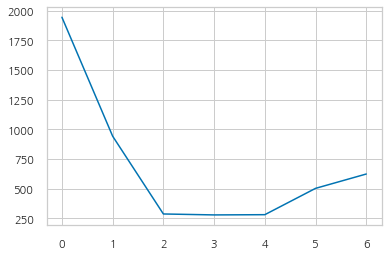

In [21]:
user_dow[user_dow.percent_of_orders >=0.8].order_dow.value_counts().sort_index().plot()

In [30]:
# 유저의 전체 주문 중 특정 시간에 주문을 80%이상 진행한 유저
user_hod[user_hod.percent_of_orders >=0.8].order_hour_of_day.value_counts().sort_index()

0      1
5      1
6      1
7     12
8     39
9     92
10    65
11    65
12    46
13    57
14    33
15    48
16    52
17    48
18    45
19    27
20     7
21    14
22     3
23     1
Name: order_hour_of_day, dtype: int64

<AxesSubplot:>

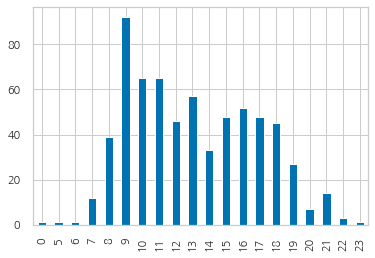

In [23]:
# 시간 선호유저 분포 시각화
# 50% 이상 구매하는 시간이 있는 유저 수 23088
# 80% 이상 구매하는 시간이 있는 유저 수 657

user_hod = prior_order_feats.groupby(['user_id', 'order_hour_of_day']).size().reset_index().rename(columns=({0:'hod_count'}))
user_hod = user_hod.merge(user_feats[['user_id', 'U_total_orders']], on='user_id', how='left')
user_hod['percent_of_orders'] = user_hod.hod_count / user_hod.U_total_orders
user_hod[user_hod.percent_of_orders >=0.8].user_id.nunique() 

user_hod[user_hod.percent_of_orders >=0.8].order_hour_of_day.value_counts().sort_index().plot.bar()

<AxesSubplot:>

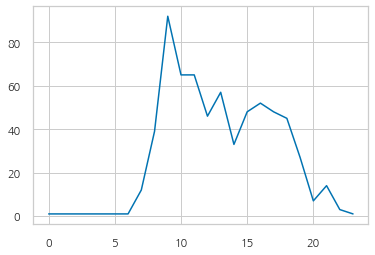

In [24]:
user_hod[user_hod.percent_of_orders >=0.8].order_hour_of_day.value_counts().sort_index().plot()

# 3. Order에서 구매 패턴 확인하기

## 3.1. `order_number(구매횟수)가 높은 주문일수록 재구매율이 높을 것이다`

In [32]:
order_num_over_40 = prior_df[prior_df.order_number >= 40]
print('평균 재구매 제품 포함 비율 :', prior_order_feats[prior_order_feats.order_number != 1].reorder_in_order.mean())

평균 재구매 제품 포함 비율 : 0.6396946724614132


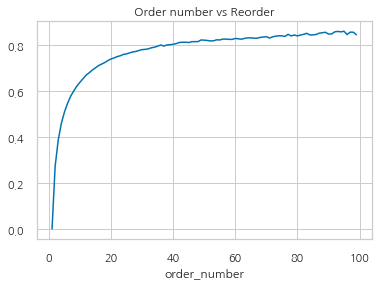

In [33]:
prior_df.groupby('order_number').reordered.mean().plot()
plt.title('Order number vs Reorder')
plt.show()

In [34]:
print('전체 데이터 재구매 비율 :', prior_df[prior_df.order_number != 1].reordered.mean())

전체 데이터 재구매 비율 : 0.6300655798652944


In [35]:
print('40회 이상 주문한 유저 수 :', order_num_over_40.user_id.nunique())

40회 이상 주문한 유저 수 : 17902


In [36]:
print('전체 주문에서 40회 이상 주문 비율 :', order_num_over_40.order_id.nunique() / prior_order_feats.shape[0])

전체 주문에서 40회 이상 주문 비율 : 0.11253722540914511


In [37]:
# 40회 이상 주문 제품 정보
order_num_over_40_prods = order_num_over_40.astype({'product_name': np.object0}).groupby('product_name').agg(total_orders=('product_id','count'), 
                                                                              total_reorders=('reordered', 'sum')).sort_values('total_orders')[::-1].reset_index()
order_num_over_40_prods

,product_name,total_orders,total_reorders
0,Bag of Organic Bananas,59102,57546.0
1,Banana,52271,51293.0
2,Organic Strawberries,31428,30444.0
3,Organic Hass Avocado,29910,29011.0
4,Organic Baby Spinach,27652,26687.0
...,...,...,...
38001,Strong & Kind Roasted Jalapeno Almond Protein Bar,1,1.0
38002,Flavor Blasted Xtra Cheddar + Pretzal Baked Sn...,1,0.0
38003,Flavor Blasted Wild White Cheddar Goldfish Cra...,1,0.0
38004,Flat to Volume Pantene Pro-V Sheer Volume Sham...,1,0.0


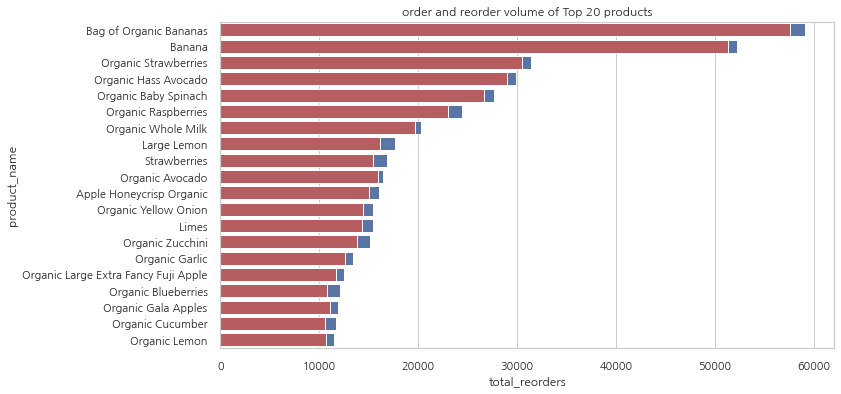

In [38]:
plt.figure(figsize=(11, 6))
plt.title('order and reorder volume of Top 20 products')
sns.barplot(x='total_orders', y='product_name', data=order_num_over_40_prods.head(20), color=color[0])
sns.barplot(x='total_reorders', y='product_name', data=order_num_over_40_prods.head(20), color=color[3])
plt.show()

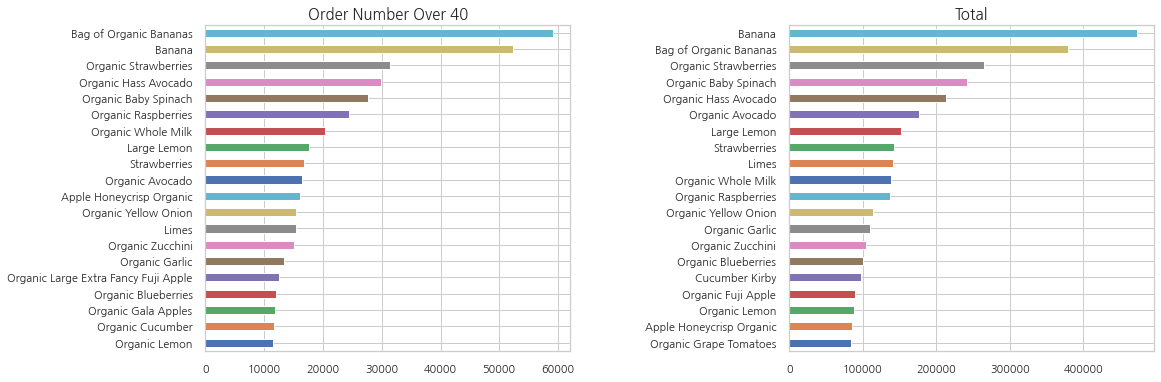

In [67]:
# over_40 유저들의 판매량 높은 제품 비중과 전체 판매량 비중의 비교
f,ax = plt.subplots(1, 2, figsize=(17, 6))
plt.subplots_adjust(wspace=0.6)
order_num_over_40.product_name.value_counts().head(20)[::-1].plot.barh(ax=ax[0], color=color)
ax[0].set_title('Order Number Over 40', fontsize=15)
ax[0].set_ylabel('')
prior_df.product_name.value_counts().head(20)[::-1].plot.barh(ax=ax[1], color=color)
ax[1].set_title('Total', fontsize=15)
ax[1].set_ylabel('')
plt.show()

In [66]:
# 40회 이상 주문과 전체 주문 제품 판매량 비교
# order_num_over_40_prods.head(20).join(prod_feats[['product_name', 'P_total_orders', 'P_total_reorders']].head(20), )
pd.concat([order_num_over_40_prods.head(20).reset_index(drop=True), prod_feats[['product_name', 'P_total_orders', 'P_total_reorders']].head(20)],axis=1)

,product_name,total_orders,total_reorders,product_name,P_total_orders,P_total_reorders
0,Bag of Organic Bananas,59102,57546.0,Banana,472565,398609.0
1,Banana,52271,51293.0,Bag of Organic Bananas,379450,315913.0
2,Organic Strawberries,31428,30444.0,Organic Strawberries,264683,205845.0
3,Organic Hass Avocado,29910,29011.0,Organic Baby Spinach,241921,186884.0
4,Organic Baby Spinach,27652,26687.0,Organic Hass Avocado,213584,170131.0
5,Organic Raspberries,24388,22959.0,Organic Avocado,176815,134044.0
6,Organic Whole Milk,20307,19625.0,Large Lemon,152657,106255.0
7,Large Lemon,17632,16112.0,Strawberries,142951,99802.0
8,Strawberries,16843,15430.0,Limes,140627,95768.0
9,Organic Avocado,16478,15889.0,Organic Whole Milk,137905,114510.0


In [42]:
# 마지막 주문에서 order_nuber 40이상의 비율
orders[(orders.eval_set != 'prior') & (orders.order_number >= 40)].shape[0] / orders[(orders.eval_set != 'prior')].shape[0]

0.09107264959337372

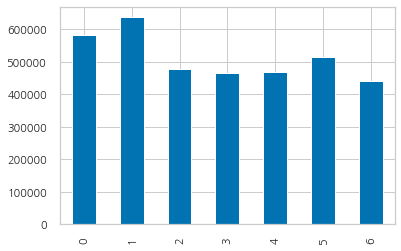

In [43]:
# 40회 이상 유저들이 주로 구매하는 요일
order_num_over_40.order_dow.value_counts().sort_index().plot.bar()
plt.show()

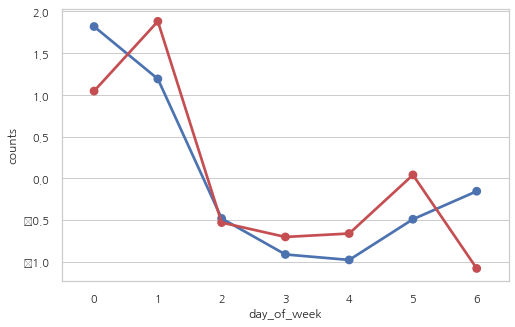

In [44]:
from sklearn.preprocessing import StandardScaler

total_orders = prior_df.order_dow.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                'order_dow': 'counts'})).set_index('day_of_week')
over_40 = order_num_over_40.order_dow.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                    'order_dow': 'counts'})).set_index('day_of_week')

ss = StandardScaler()
total_orders['counts'] = ss.fit_transform(total_orders)
over_40['counts'] = ss.fit_transform(over_40)

plt.figure(figsize=(8, 5))
sns.pointplot(x=total_orders.index, y='counts', data=total_orders, color=color[0], label='total')
sns.pointplot(x=over_40.index, y='counts', data=over_40, color=color[3], label='over40')
plt.show()

In [45]:
total_orders = prior_df.order_hour_of_day.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                'order_hour_of_day': 'counts'})).set_index('day_of_week')
over_40 = order_num_over_40.order_hour_of_day.value_counts().reset_index().rename(columns=({'index': 'day_of_week', 
                                                                                    'order_hour_of_day': 'counts'})).set_index('day_of_week')

ss = StandardScaler()
total_orders['counts'] = ss.fit_transform(total_orders)
over_40['counts'] = ss.fit_transform(over_40)

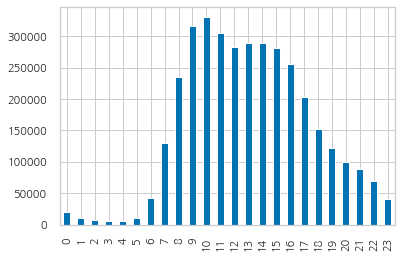

In [46]:
# 40회 이상 유저들이 주로 구매하는 시간
order_num_over_40.order_hour_of_day.value_counts().sort_index().plot.bar()
plt.show()

## 3.2. `days_since_prior_order가 짧은 주문일수록 재구매율이 높을 것이다`


In [47]:
prior_order_feats.head()

,user_id,order_number,basket_size,reorder_in_order,order_dow,order_hour_of_day,days_since_prior_order,order_id
0,1,1,5,0.000,2,8,NaN,2539329
1,1,2,6,0.500,3,7,15.0,2398795
2,1,3,5,0.600,3,12,21.0,473747
3,1,4,5,1.000,4,7,29.0,2254736
4,1,5,8,0.625,4,15,28.0,431534


<AxesSubplot:ylabel='days_since_prior_order'>

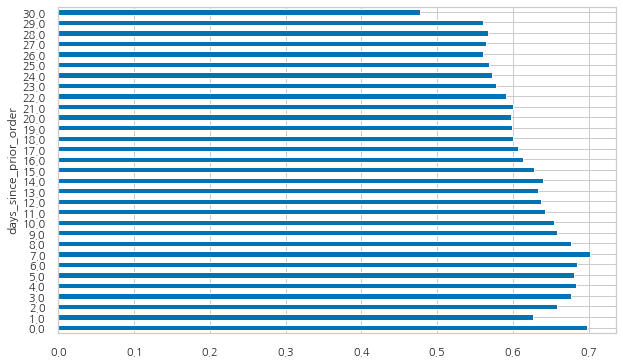

In [48]:
plt.figure(figsize=(10, 6))
prior_order_feats.groupby('days_since_prior_order').reorder_in_order.mean().plot.barh()

In [49]:
# 재주문 기간 별 평균 재주문 제품 포함 비율
prior_order_feats.groupby('days_since_prior_order').reorder_in_order.mean()

days_since_prior_order
0.0     0.697275
1.0     0.626863
2.0     0.658052
3.0     0.676392
4.0     0.683834
5.0     0.680283
6.0     0.684224
7.0     0.701646
8.0     0.676970
9.0     0.658714
10.0    0.654191
11.0    0.642443
12.0    0.636483
13.0    0.633204
14.0    0.640056
15.0    0.627351
16.0    0.613181
17.0    0.606415
18.0    0.599964
19.0    0.598253
20.0    0.597318
21.0    0.600399
22.0    0.591121
23.0    0.578212
24.0    0.572575
25.0    0.568141
26.0    0.560020
27.0    0.565067
28.0    0.567501
29.0    0.559942
30.0    0.477778
Name: reorder_in_order, dtype: float64

<AxesSubplot:>

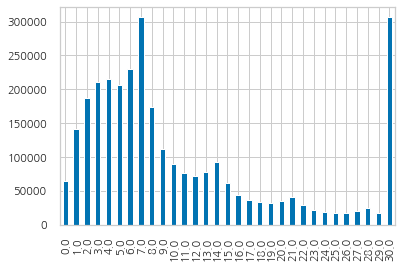

In [50]:
prior_order_feats.days_since_prior_order.value_counts().sort_index().plot.bar()

In [51]:
# 재주문 기간 별 주문 수
prior_order_feats.days_since_prior_order.value_counts().sort_index()

0.0      64436
1.0     141011
2.0     187723
3.0     210665
4.0     214488
5.0     206691
6.0     230245
7.0     306181
8.0     173259
9.0     112184
10.0     90198
11.0     76394
12.0     71356
13.0     77765
14.0     93064
15.0     61883
16.0     43423
17.0     36281
18.0     33050
19.0     31408
20.0     35173
21.0     41262
22.0     29125
23.0     21629
24.0     18704
25.0     17324
26.0     17120
27.0     19677
28.0     23833
29.0     16976
30.0    306137
Name: days_since_prior_order, dtype: int64

# 4. 고객별 구매 패턴

## 4.1. 유저 개개인은 선호하는 제품 or 구매 패턴이 존재할 것 이다.



In [52]:
# 유저마다 주문율 80%이상인 제품이 있는지 확인. 이 유저는 이건 매번 사더라
print('유저별 전체 주문에서 80%이상 구매한 제품이 있는 유저 수 :', user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].user_id.nunique())

유저별 전체 주문에서 80%이상 구매한 제품이 있는 유저 수 : 72113


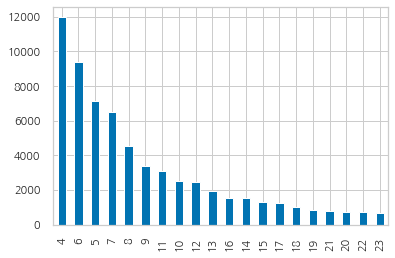

In [53]:
# 위의 유저들의 order_number 확인
orders[orders.user_id.isin(user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].user_id.unique())].groupby('user_id').order_number.max().value_counts().head(20).plot.bar()
plt.show()

In [54]:
user_prod_feats[user_prod_feats.UP_order_percentage >= 0.8].groupby('product_name').product_id.count().sort_values()[::-1].reset_index().rename(columns={'product_id': 'count'}).head(20)

,product_name,count
0,Banana,8258
1,Bag of Organic Bananas,4639
2,Organic Avocado,1904
3,Organic Baby Spinach,1724
4,Organic Whole Milk,1700
5,Organic Hass Avocado,1402
6,Organic Strawberries,1154
7,Spring Water,1066
8,Sparkling Water Grapefruit,864
9,Strawberries,830


## 4.2. 같은 제품을 우선순위로 두는 유저들의 구매 패턴은 비슷할 것 이다.

In [55]:
def make_band(x):
    if x < 2:
        return 1
    if x < 3:
        return 2
    if x < 4:
        return 3
    if x < 5:
        return 4
    if x < 6:
        return 5
    if x < 7:
        return 6
    if x < 8:
        return 7
    if x < 9:
        return 8
    if x < 10:
        return 9
    if x < 11:
        return 10
    if x < 12:
        return 11
    if x < 13:
        return 12
    if x < 14:
        return 13

user_prod_feats['UP_mean_cart_order_band'] = user_prod_feats[user_prod_feats.UP_mean_cart_order <= 14].UP_mean_cart_order.apply(make_band)
user_prod_feats.head()

,user_id,product_id,UP_total_orders,UP_total_reorders,UP_mean_cart_order,U_total_orders,UP_reorder_ratio,UP_order_percentage,UP_order_days,UP_mean_days_since_prior_order,UP_order_3,UP_order_2,UP_order_1,product_name,aisle_id,department_id,UP_mean_cart_order_band
0,1,196,10,9,1.400000,10,1.00,1.0,176,19.555555,1,1,1,Soda,77,7,1.0
1,1,12427,10,9,3.300000,10,1.00,1.0,176,19.555555,1,1,1,Original Beef Jerky,23,19,3.0
2,1,10258,9,8,3.333333,10,1.00,0.9,161,20.125000,1,1,1,Pistachios,117,19,3.0
3,1,25133,8,7,4.000000,10,1.00,0.8,140,20.000000,1,1,1,Organic String Cheese,21,16,4.0
4,1,13032,3,2,6.333333,10,0.25,0.3,50,25.000000,-1,-1,1,Cinnamon Toast Crunch,121,14,6.0


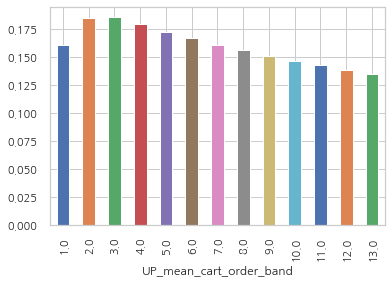

In [56]:
# 평균 장바구니 순위 14이하 별 주문율
user_prod_feats.groupby('UP_mean_cart_order_band').UP_order_percentage.mean().plot.bar(color=color)
plt.show()

In [68]:
# volume_over_30 = prod_feats.head(int(prod_feats.shape[0] * 0.30))
volume_over_30.head()

NameError: name 'volume_over_30' is not defined

In [ ]:
volume_over_30.sort_values(['P_mean_cart_order', 'P_reorder_rate'], ascending=([True, False]))

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
11968,31380,277,137,140.0,0.505415,2.628159,2691.0,19.642336,7.866771,Omeprazole Acid Reducer Tablets,...,7.829159,2.360676,digestion,447123,143584.0,0.321129,8.752753,1.727874,personal care,8
2528,35470,2244,389,1855.0,0.826649,2.688948,20892.0,53.706941,9.938788,Water Mineral,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
7345,42791,600,220,380.0,0.633333,2.746667,6436.0,29.254545,8.060704,Minis to Go Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9
9656,49463,394,131,263.0,0.667513,2.875635,4428.0,33.801527,10.141673,Organic Whole Bean Coffee,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,11
12899,1071,243,95,148.0,0.609053,2.880658,1665.0,17.526316,6.067930,Pils,...,5.342315,3.703812,beers coolers,153696,87595.0,0.569924,5.428346,3.471192,alcohol,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11278,7347,306,148,158.0,0.516340,14.245098,1306.0,8.824324,2.252465,Kiwi Beet & Pear Strawberry Pouch,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,3
14237,40863,202,145,57.0,0.282178,14.801980,370.0,2.551724,1.316437,Summer Vegetable Dinner Stage 2,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,2
11715,12822,288,210,78.0,0.270833,14.809028,384.0,1.828571,0.656389,Pureed Baby Food Strawberries Carrots,...,10.762161,3.744503,baby food formula,423802,245369.0,0.578971,10.575925,3.611420,babies,1
11642,3888,291,85,206.0,0.707904,15.000000,1865.0,21.941176,4.347333,Organic Chile Lemon Pistachio,...,9.319779,3.124956,nuts seeds dried fruit,2887550,1657973.0,0.574180,9.187743,3.943013,snacks,5


In [ ]:
user_prod_feats.columns

Index(['user_id', 'product_id', 'UP_total_orders', 'UP_total_reorders',
       'UP_mean_cart_order', 'U_total_orders', 'UP_reorder_ratio',
       'UP_order_percentage', 'UP_order_days',
       'UP_mean_days_since_prior_order', 'UP_order_3', 'UP_order_2',
       'UP_order_1', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

In [ ]:
user_prod_feats.sort_values(['UP_mean_cart_order', 'UP_total_orders'], ascending=[True, False]).head(10)

,user_id,product_id,UP_total_orders,UP_total_reorders,UP_mean_cart_order,U_total_orders,UP_reorder_ratio,UP_order_percentage,UP_order_days,UP_mean_days_since_prior_order,UP_order_3,UP_order_2,UP_order_1,product_name,aisle_id,department_id
11155119,172689,1463,52,51,1.0,60,0.864407,0.866667,208,4.078432,1,1,1,Organic Milk,84,16
13112040,203143,48239,50,49,1.0,53,0.942308,0.943396,269,5.489796,1,1,1,Cocoa Spread with Hazelnuts,88,13
5558214,85854,34050,49,48,1.0,51,0.960000,0.960784,348,7.250000,-1,1,1,Orange Juice,31,7
6866806,105998,10602,49,48,1.0,49,1.000000,1.000000,262,5.458333,1,1,1,Brioche Hamburger Buns,43,3
10991151,170174,32478,47,46,1.0,47,1.000000,1.000000,280,6.086957,1,1,1,Reduced Fat 2% Milk,84,16
763118,12025,34050,45,44,1.0,45,1.000000,1.000000,316,7.181818,1,1,1,Orange Juice,31,7
10688249,165398,19660,44,43,1.0,61,0.767857,0.721311,282,6.558139,1,1,1,Spring Water,115,7
4603475,71217,22046,39,38,1.0,44,0.883721,0.886364,319,8.394737,1,-1,1,Frozen Whole Strawberries,116,1
12110815,187579,19660,39,38,1.0,39,1.000000,1.000000,204,5.368421,1,1,1,Spring Water,115,7
11170984,172935,6137,38,37,1.0,38,1.000000,1.000000,225,6.081081,1,1,1,Merlot,28,5


In [ ]:
prior_df[prior_df.add_to_cart_order == 1].product_id.nunique()

41826

In [ ]:
# 제품별로 카트에 담긴 평균을 낸 후, p_mean_cart_order가 낮은 제품 중 판매량이 높은 제품리스트을를 확인하려 했으나
# 평균 카트 순위와 제품의 판매량은 상관관계가 보이지 않아 멈춤
volume_over_30.sort_values('P_mean_cart_order').head(10)

,product_id,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,P_sum_order_days,P_mean_order_days,P_days_since_prior_order,product_name,...,A_avg_cart_order,A_mean_days_since_prior_order,aisle,D_total_orders,D_total_reorders,D_reorder_rate,D_avg_cart_order,D_mean_days_since_prior_order,department,dspo_band
11968,31380,277,137,140.0,0.505415,2.628159,2691.0,19.642336,7.866771,Omeprazole Acid Reducer Tablets,...,7.829159,2.360676,digestion,447123,143584.0,0.321129,8.752753,1.727874,personal care,8
2528,35470,2244,389,1855.0,0.826649,2.688948,20892.0,53.706941,9.938788,Water Mineral,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
7345,42791,600,220,380.0,0.633333,2.746667,6436.0,29.254545,8.060704,Minis to Go Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9
9656,49463,394,131,263.0,0.667513,2.875635,4428.0,33.801527,10.141673,Organic Whole Bean Coffee,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,11
12899,1071,243,95,148.0,0.609053,2.880658,1665.0,17.526316,6.067930,Pils,...,5.342315,3.703812,beers coolers,153696,87595.0,0.569924,5.428346,3.471192,alcohol,7
588,20940,8438,1398,7040.0,0.834321,2.881251,93742.0,67.054363,12.102471,Organic Low Fat Milk,...,5.570370,6.848756,milk,5414016,3627221.0,0.669969,7.495423,5.249701,dairy eggs,13
3475,11885,1556,394,1162.0,0.746787,2.902956,15224.0,38.639594,7.969280,"Sparkling Water, Bottles",...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,8
8412,12640,490,127,363.0,0.740816,2.983673,5533.0,43.566929,9.244006,Sport Bottle with Flip Cap Natural Spring Water,...,6.084061,6.370446,water seltzer sparkling water,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,10
2542,26900,2231,782,1449.0,0.649485,3.012999,20644.0,26.398977,8.955139,USDA AA Extra Large Eggs,...,6.430567,6.685965,eggs,5414016,3627221.0,0.669969,7.495423,5.249701,dairy eggs,9
9292,4100,419,93,326.0,0.778043,3.047733,3766.0,40.494624,8.795648,Organic Dark Roast,...,7.208847,4.294433,coffee,2690129,1757892.0,0.653460,6.976699,4.778593,beverages,9


# 5. 제품별 판매 패턴

## 5.1. 고객들이 선호하는 제품 키워드가 존재하고 재주문율이 높을 것이다. 

### 5.1.1. word cloud로 제품 키워드 파악 후 키워드 별 재주문율 확인

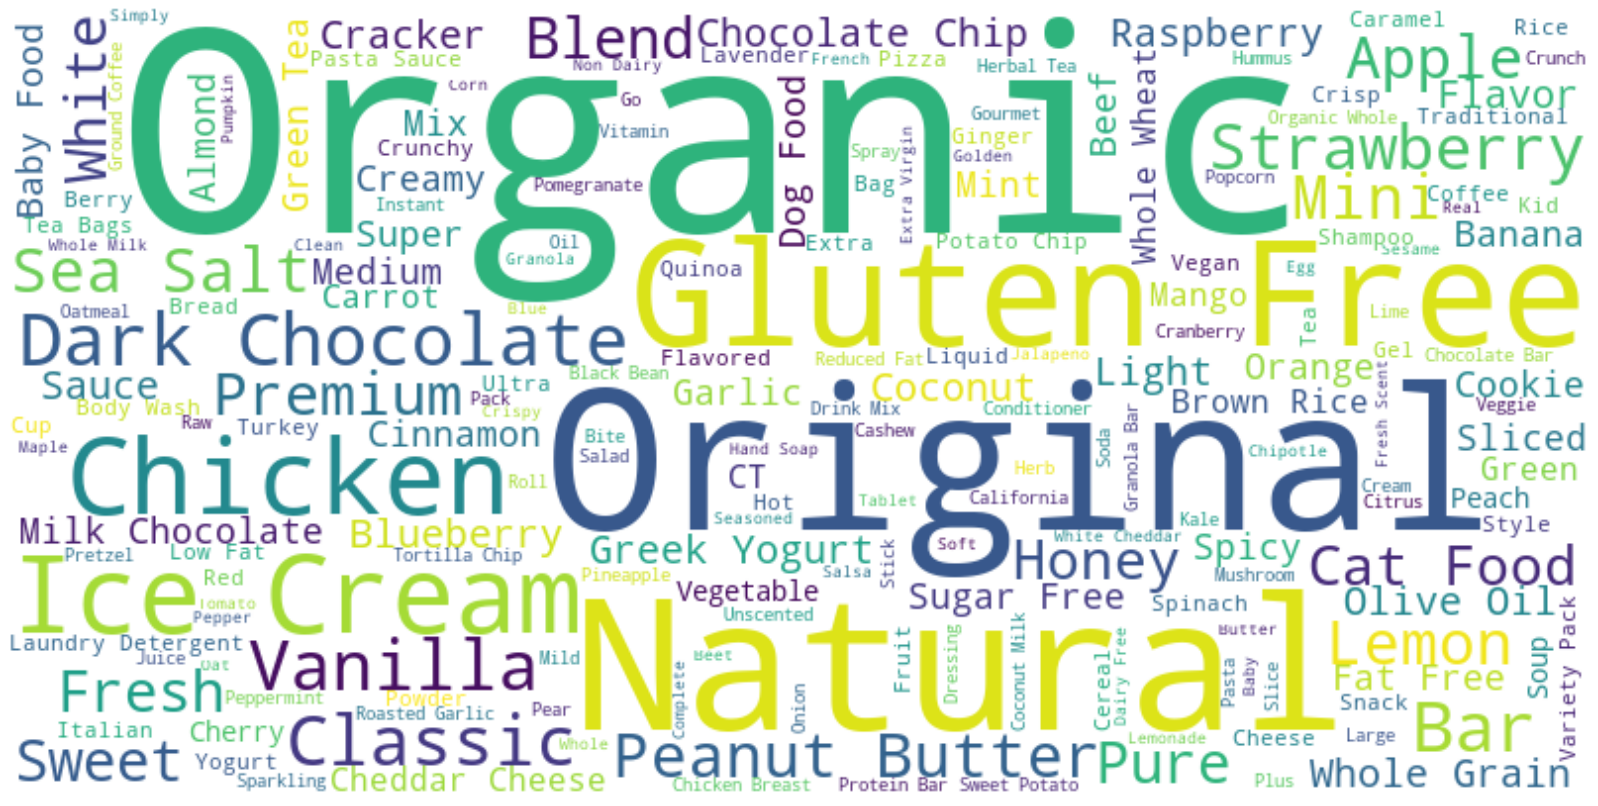

In [ ]:
# 제품 이름 내 키워드 분석
from wordcloud import WordCloud,ImageColorGenerator

#making of word cloud from Product name column
text = " ".join(topic for topic in prod_feats.product_name.astype(str))
print ("There are {} words in the combination of all Product Name.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (23,11)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
# 단어 리스트 생성
word_list_lower =  ["organic", 'fat', "whole", "reduced", 'baby', "water", "banana", "greek", "hass", "strawberry", "honey", 'half']
word_list_upper = ["Organic", 'Fat', "Whole", "Reduced", "Baby", "Water", "Banana", "Greek", "Hass", "Strawberry", "Honey", 'Half']

In [ ]:
# 단어가 포함된 제품과 그렇지 않은 제품의 재주문율 비교
def is_name(word_low, word_up, df):  
    df[word_low] = df.product_name.apply(lambda x: 1 if word_low in x or word_up in x else 0)
    print(word_up, df.groupby(word_low)['reordered'].mean())

In [ ]:
# 1차
df = prior_df.copy()
for word_low, word_up in zip(word_list_lower, word_list_upper):
    is_name(word_low, word_up, df)

Organic organic
0    0.568799
1    0.634926
Name: reordered, dtype: float64
Fat fat
0    0.584969
1    0.700573
Name: reordered, dtype: float64
Natural natural
0    0.590096
1    0.571313
Name: reordered, dtype: float64
Chicken chicken
0    0.590719
1    0.548342
Name: reordered, dtype: float64
Baby baby
0    0.587684
1    0.651103
Name: reordered, dtype: float64
Ice Cream ice cream
0    0.590522
1    0.489287
Name: reordered, dtype: float64
Sweet sweet
0    0.589612
1    0.592591
Name: reordered, dtype: float64
Greek greek
0    0.587902
1    0.682447
Name: reordered, dtype: float64
Free free
0    0.589336
1    0.598605
Name: reordered, dtype: float64
Fresh fresh
0    0.590715
1    0.513731
Name: reordered, dtype: float64
Classic classic
0    0.590198
1    0.527083
Name: reordered, dtype: float64
Premium premium
0    0.590095
1    0.504240
Name: reordered, dtype: float64
Chocolate chocolate
0    0.590275
1    0.569555
Name: reordered, dtype: float64
Strawberry strawberry
0    0.589172


In [ ]:
# 2차
for word_low, word_up in zip(word_list_lower, word_list_upper):
    is_name(word_low, word_up, df)

Organic organic
0    0.568799
1    0.634926
Name: reordered, dtype: float64
Fat fat
0    0.584969
1    0.700573
Name: reordered, dtype: float64
Whole whole
0    0.587086
1    0.655623
Name: reordered, dtype: float64
Reduced reduced
0    0.588148
1    0.735362
Name: reordered, dtype: float64
Baby baby
0    0.587684
1    0.651103
Name: reordered, dtype: float64
Water water
0    0.585755
1    0.702736
Name: reordered, dtype: float64
Banana banana
0    0.582836
1    0.799929
Name: reordered, dtype: float64
Greek greek
0    0.587902
1    0.682447
Name: reordered, dtype: float64
Hass hass
0    0.587923
1    0.755085
Name: reordered, dtype: float64
Gluten gluten
0    0.590085
1    0.563921
Name: reordered, dtype: float64
Strawberry strawberry
0    0.589172
1    0.625552
Name: reordered, dtype: float64
Honey honey
0    0.589160
1    0.621237
Name: reordered, dtype: float64
Cream cream
0    0.591216
1    0.542048
Name: reordered, dtype: float64


In [ ]:
is_name('half', 'Half', df)

Half half
0    0.588802
1    0.737455
Name: reordered, dtype: float64


In [ ]:
is_name('sugar', 'Sugar', df)

Sugar sugar
0    0.590602
1    0.462926
Name: reordered, dtype: float64


In [ ]:
is_name('sodium', 'Sodium', df)

Sodium sodium
0    0.590269
1    0.432693
Name: reordered, dtype: float64


In [ ]:
df.groupby('water').reordered.mean()

water
0    0.585755
1    0.702736
Name: reordered, dtype: float64